Max value: 183.0
Best super arm: [0.0, 7.0, 0.0, 6.0, 7.0]


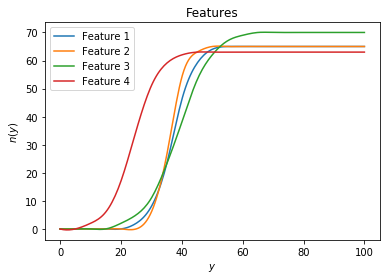

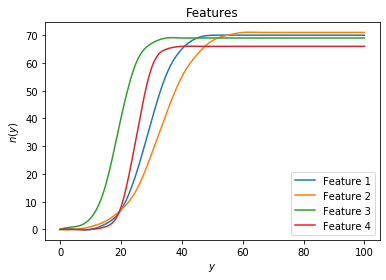

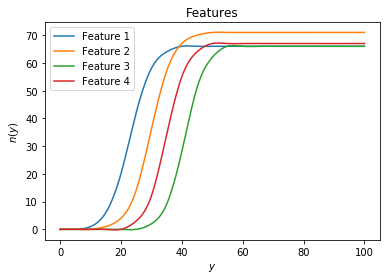

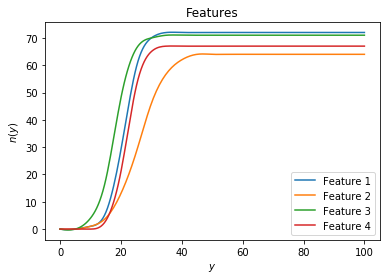

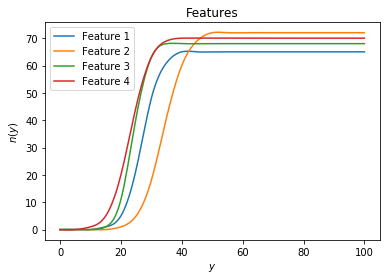

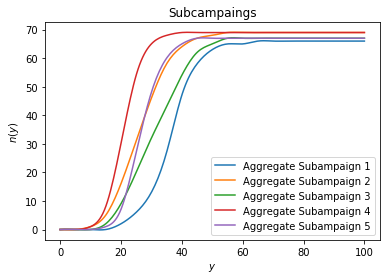

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline
from scipy import stats

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C


class Bidding_Environment():
    def __init__(self, daily_budgets,fun, sigma):
        self.daily_budgets = daily_budgets
        self.means = fun
        self.sigmas = np.ones(len(daily_budgets))*sigma

    def round(self, pulled_arm):
        return np.maximum(np.random.normal(self.means[pulled_arm],self.sigmas[pulled_arm]),0.)
  
class Learner():
    def __init__(self, n_arms):
        self.n_arms = n_arms
        self.t = 0
        self.rewards_per_arm = x = [[] for i in range(n_arms)]
        self.collected_rewards = np.array([])
        self.arm_pulled = []

    def update_observations(self, pulled_arm, reward):
        self.rewards_per_arm[pulled_arm].append(reward)
        self.collected_rewards = np.append(self.collected_rewards,reward)
        self.arm_pulled.append(pulled_arm)

class GPTS_Learner(Learner):
    def __init__(self, n_arms, arms):
        super().__init__(n_arms)
        self.arms = arms
        self.means = np.zeros(n_arms)
        self.sigmas = np.ones(n_arms) * 10
        self.pulled_arms = []
        alpha = 10.0

        kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-3, 1e3))
        self.gp = GaussianProcessRegressor(kernel=kernel, alpha=alpha ** 2, normalize_y=True, n_restarts_optimizer=10)

    def update_observations(self, arm_idx, reward):
        super().update_observations(arm_idx, reward)
        self.pulled_arms.append(self.arms[arm_idx])

    def update_model(self):

        x = np.atleast_2d(np.asarray(self.pulled_arms) / 100.).T
        y = self.collected_rewards

        self.gp.fit(x, y)
        self.means, self.sigmas = self.gp.predict(np.atleast_2d(np.asarray(self.arms) / 100.).T, return_std=True)
        self.sigmas = np.maximum(self.sigmas, 1e-2)
        self.means = np.maximum(self.means, 0.)

    def update(self, pulled_arm, reward):
        self.t += 1
        self.update_observations(pulled_arm, reward)
        self.update_model()

    def pull_arm(self):
        sampled_values = np.random.normal(self.means, self.sigmas)
        return np.argmax(sampled_values)

class ClassFunction:

    def __init__(self, maxValue=0, growth=0, x0=0, weight=0):
        self.max = maxValue
        self.growth = growth
        self.x0 = x0
        self.weight = weight

    def getValue(self, x):
        return np.floor(self.max/(1+np.exp(-self.growth*(x-self.x0))))


class Subcampaign:

    def __init__(self, classes=[]):
        self.classes = classes

    def getValue(self, x):
        return np.floor(np.sum([c.weight * c.getValue(x) for c in list(self.classes)]))

    def fun(self, bud):
        return [self.getValue(x) for x in bud]

    def printSubGraph(self, budgets):
        plt.figure()
        for k, j in enumerate(self.classes):
            y = []

            for x in budgets:
                y.append(j.getValue(x))

            spl = make_interp_spline(budgets, y, k=3)
            xNew = np.linspace(0, np.asarray(budgets).max(), 200)
            plt.plot(xNew, spl(xNew), label="Feature "+str(k+1))

        plt.title("Features")
        plt.xlabel("$y$")
        plt.ylabel("$n(y)$")
        plt.legend()

        return

    def getAggregateGraph(self, budgets):
        y = []

        for x in budgets:
            y.append(self.getValue(x))

        spl = make_interp_spline(budgets, y, k=3)
        xNew = np.linspace(0, np.asarray(budgets).max(), 200)

        return xNew, spl(xNew)


class Campaign:
    def __init__(self, subcampaigns=[]):
        self.subcampaigns = subcampaigns

    def getValue(self, x):
        return np.average([c.getValue(x) for c in list(self.subcampaigns)])

    def getAggregateGraph(self, budgets):
        y = []

        for x in budgets:
            y.append(self.getValue(x))

        spl = make_interp_spline(budgets, y, k=3)
        xNew = np.linspace(0, np.asarray(budgets).max(), 200)

        return xNew, spl(xNew)


def optimize(N, budgets, subclicks, plan, click_value):

    click = [np.zeros((len(budgets))) for j in range(N+1)]
    arm = [np.zeros((len(budgets))) for j in range(N+1)]
    oldarm = [np.zeros((len(budgets))) for j in range(N+1)]

    for i in range(N):
        for j in range(len(budgets)):
            temp = []
            for k in range(j+1):
                temp.append(click[i][j-k] + subclicks[i][k])

            click[i+1][j] = np.max(temp)
            arm[i+1][j] = np.argmax(temp)
            oldarm[i+1][j] = j-np.argmax(temp)

    return click, arm, oldarm


def getSuperArm(click, arm, oldarm):
    res = []

    v = int(np.argmax(click[N-1]))
    for i in range(N):
        res.append(arm[N-i][v])
        v = int(oldarm[N-i][v])

    res.reverse()
    return res


np.random.seed(111)
N = 5
budgets = np.linspace(0, 100, 21)
subcampaigns = []

features = {
    "gender": {"male": 0.6, "female": 0.4},
    "age": {"young": 0.7, "old": 0.3}
}
for i in range(N):
    classes = []
    for _, v1 in features['gender'].items():
        for _, v2 in features['age'].items():
            classes.append(ClassFunction(np.random.randint(
                62, 77), np.random.randint(16, 41)/100.0, np.random.randint(17, 42), v1*v2))
    subcampaigns.append(Subcampaign(classes))

    subcampaigns[i].printSubGraph(budgets)

campaign = Campaign(subcampaigns)


plt.figure()
for i in range(N):
    x, y = subcampaigns[i].getAggregateGraph(budgets)
    plt.plot(x, y, label="Aggregate Subampaign "+str(i+1))

plan = []
subclick = []
click_value = 1.0
max_v = 100
for j in range(N):
    plan.append([0, max_v])
    subclick.append([campaign.subcampaigns[j].getValue(x) for x in budgets])

click, arm, oldarm = optimize(N, budgets, subclick, plan, click_value)

print("Max value: " + str(np.max(click[N])))
print("Best super arm: " + str(getSuperArm(click, arm, oldarm)))


plt.title("Subcampaings")
plt.xlabel("$y$")
plt.ylabel("$n(y)$")
plt.legend()
plt.show()

In [0]:
import pandas as pd

pd.DataFrame(click,
             index=pd.Index(["C"+str(i) for i in range(N+1)]),
             columns=[budgets[i] for i in range(len(budgets))])

,0.0,5.0,10.0,15.0,20.0,25.0,30.0,35.0,40.0,45.0,50.0,55.0,60.0,65.0,70.0,75.0,80.0,85.0,90.0,95.0,100.0
C0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C1,0.0,0.0,0.0,0.0,2.0,6.0,13.0,27.0,47.0,58.0,63.0,65.0,65.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0
C2,0.0,0.0,1.0,5.0,16.0,31.0,46.0,58.0,64.0,67.0,68.0,69.0,69.0,78.0,93.0,105.0,116.0,122.0,127.0,130.0,132.0
C3,0.0,0.0,1.0,5.0,16.0,31.0,46.0,58.0,64.0,67.0,68.0,69.0,78.0,90.0,101.0,112.0,120.0,126.0,129.0,132.0,134.0
C4,0.0,0.0,1.0,8.0,30.0,54.0,65.0,68.0,69.0,70.0,85.0,100.0,112.0,123.0,129.0,132.0,135.0,136.0,144.0,155.0,166.0
C5,0.0,0.0,1.0,8.0,30.0,54.0,65.0,68.0,69.0,70.0,85.0,102.0,114.0,125.0,130.0,133.0,135.0,148.0,160.0,172.0,183.0


In [0]:
T = 100
n_experiments = 50

rewards = [[] for j in range(N)]
arms = [[] for j in range(N)]

means = [[] for j in range(N)]
sigmas = [[] for j in range(N)]

M = np.zeros((n_experiments, T, N+1, len(budgets)), dtype=int)
A = np.zeros((n_experiments, T, N+1, len(budgets)))
V = np.zeros((n_experiments, T, N+1, len(budgets)))
best_arms = np.zeros((n_experiments, T, N), dtype=int)
B = [[0, 100] for j in range(N)]
theta, l = 1, 1
noise_std = 5.0
reg_error = np.zeros((n_experiments, N, T))
gpts_rewards_per_experiment = np.zeros((n_experiments, T))

for exp in range(n_experiments):
  learners = [GPTS_Learner(len(budgets),budgets) for j in range(N)]
  envs = [Bidding_Environment(daily_budgets=budgets, fun=subclick[j], sigma=noise_std) for j in range(N)]

  
  
  for t in range(T):
    vals = [[]for j in range(N)]
    for j in range(N):
            
      arm_pulled = learners[j].pull_arm()
      reward = envs[j].round(arm_pulled)
      learners[j].update(arm_pulled, reward)
            
      arms[j].append(learners[j].arm_pulled)
      rewards[j].append(learners[j].collected_rewards)
      means[j].append(learners[j].means)
      sigmas[j].append(learners[j].sigmas)
      
      reg_error[exp][j][t] = np.max(np.absolute((learners[j].means - envs[j].means)))
      vals[j] = (learners[j].means.tolist())
    
    M[exp][t], A[exp][t], V[exp][t] = optimize(N, budgets, vals, B, click_value)
    
    best_arms[exp][t] = getSuperArm(M[exp][t], A[exp][t], V[exp][t])
    test = 0
    for lo in range(N):
      test += campaign.subcampaigns[lo].getValue(budgets[best_arms[exp][t][lo]])

    gpts_rewards_per_experiment[exp][t] = test


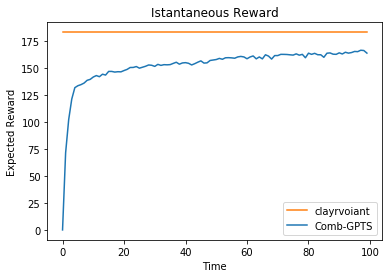

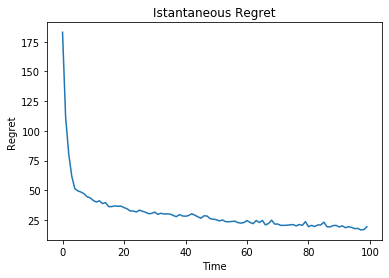

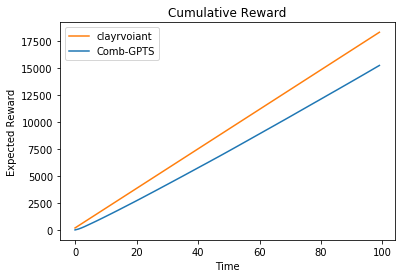

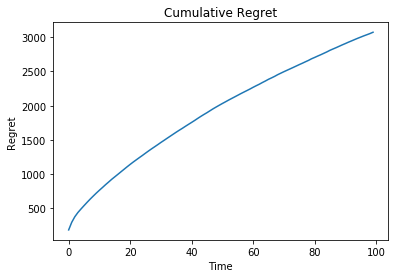

In [0]:
true_arm = getSuperArm(click, arm, oldarm)
clairvoyant = np.sum([1 * envs[j].means[int(true_arm[j])] for j in range(N)], axis=0)

reward_nc = np.average(gpts_rewards_per_experiment,axis=0)

plt.figure()
plt.title("Istantaneous Reward")
plt.plot(range(T), T * [clairvoyant], label='clayrvoiant', color="C1")
plt.plot(range(T), reward_nc, label='Comb-GPTS', color="C0")
plt.xlabel("Time")
plt.ylabel("Expected Reward")
plt.legend()
plt.show()

plt.figure()
plt.title("Istantaneous Regret")
plt.plot(range(T), np.absolute(T * [clairvoyant] - reward_nc))
plt.xlabel("Time")
plt.ylabel("Regret")
plt.show()

plt.figure()
plt.title("Cumulative Reward")
plt.plot(range(T), np.cumsum(T * [clairvoyant]), label='clayrvoiant', color="C1")
plt.plot(range(T), np.cumsum(reward_nc), label='Comb-GPTS', color="C0")
plt.xlabel("Time")
plt.ylabel("Expected Reward")
plt.legend()
plt.show()

plt.figure()
plt.title("Cumulative Regret")
plt.plot(range(T), np.cumsum(np.absolute(T * [clairvoyant] - reward_nc)))
plt.xlabel("Time")
plt.ylabel("Regret")
plt.show()

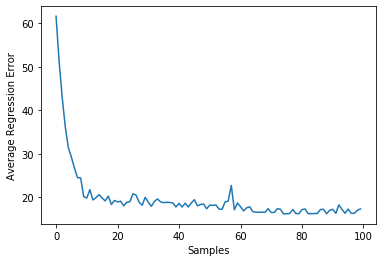

In [0]:
plt.figure()
plt.plot(range(T), np.mean(reg_error, axis=0)[0] , label="SC1")
plt.xlabel("Samples")
plt.ylabel("Average Regression Error")
plt.show()

In [0]:
class Context:
  def __init__(self, N_users):
        self.N_users = N_users
        self.data = {}
        self.index = []
        for fname in features.keys():
          for f in features[fname].keys():
            self.index.append(f)
        for f in features:
          self.data.update({f : []})


  def sample(self, N=None):
   
    sample = {}
    
    for f in features:
      sample.update({f : []})
    
    if N == None:
      N = self.N_users
      
    for x in range(N):
      
      for fname in list(features.keys()):
        p = np.random.uniform(0,1,1)
        f = list(features[fname].keys())
        
        if p > features[fname][f[0]]:
          v = f[1]
        else:
          v = f[0]
        
        sample[fname].append(v)
      
    for f in sample.keys():
      for e in sample[f]:
        self.data[f].append(e)
          
    return self.data
    
  def split(self, mu_c0, p_c1, mu_c1, p_c2, mu_c2):

    if p_c1 * mu_c1 + p_c2 * mu_c2 >= mu_c0:
      return True
    else:
      return False
    
  def update_even_node(self, context, features, p, val):
      
      if len(features) == 0:
        return context
      
      else:
        fname = list(features.keys())[0]
        f = list(features[fname].keys())
        return self.update_odd_node(context, features, fname, f, p, val)
        
  def update_odd_node(self, context, features, fname, f, p, val):
    
    c_val = list(context.values())[0][0]
    if (self.split(c_val, p[f[0]], val[f[0]][0], p[f[1]], val[f[1]][0])):

      if p[f[0]] * val[f[0]][0] >= p[f[1]] * val[f[1]][0]:
        f1 = f[0]
        context = {f1 : val[f[0]]}

      else:
        f1 = f[1]
        context = {f1 : val[f[1]]}
      
    features.pop(fname)

    return self.update_even_node(context, features, p, val)
  
  def split_context(self):
          
    total = len(self.data[list(features.keys())[0]])

    bound_factor = np.sqrt(-1 * np.math.log(0.95) / (2 * total))
    
    p = {}
    for fname in features.keys():
      for f in features[fname]:
        p.update({f : self.data[fname].count(f) / np.array(total) - np.array(bound_factor)})
    
    val = {}
  
    for l,f in enumerate(list(p.keys())):
      class_mat = []
      for i in range(N):
        class_mat.append([campaign.subcampaigns[i].classes[l].getValue(x) for x in budgets])
      M, A, V = optimize(N, budgets, class_mat, B, click_value)
      bestarms = getSuperArm(M, A, V)
      bestval = np.max(M[N])
      val.update({f :  [bestval,bestarms]})    

    #print(p)

    M, A, V = optimize(N, budgets, subclick, B, click_value)
    bestarms = getSuperArm(M, A, V)
    bestval = np.max(M[N])
    
    context = {"agg": [bestval,bestarms]}
    con = [-1, bestarms]

    context = self.update_even_node(context, features.copy(), p, val)
    #print(context)
    if((list(context.keys())[0] != "agg")):
      con = [self.index.index(list(context.keys())[0]),list(context.values())[0][1]]

    return con

In [0]:
context = Context(100)

rewards = [[] for j in range(N)]
arms = [[] for j in range(N)]
means = [[] for j in range(N)]
sigmas = [[] for j in range(N)]

clairvoyant_c = np.zeros((n_experiments, T))

M_c = np.zeros((n_experiments, T, N+1, len(budgets)), dtype=int)
A_c = np.zeros((n_experiments, T, N+1, len(budgets)))
V_c = np.zeros((n_experiments, T, N+1, len(budgets)))
best_arms_c = np.zeros((n_experiments, T, N), dtype=int)

reg_error_c = np.zeros((n_experiments, N, T))
gpts_rewards_per_experiment_c = np.zeros((n_experiments, T))

for exp in range(n_experiments):
  learners_c = [GPTS_Learner(len(budgets),budgets) for j in range(N)]
  envs_c = [Bidding_Environment(daily_budgets=budgets, fun=subclick[j], sigma=noise_std) for j in range(N)]

  voy = [[-1,true_arm] for xa in range(N)]
  
  for t in range(T):
    vals_c = [[]for j in range(N)]
    context.sample()

    for j in range(N):

      if t > 0 and t % 7 == 0:
        best_feature = context.split_context()
        if(best_feature[0] >= 0):
          envs_c[j].means = [campaign.subcampaigns[j].classes[best_feature[0]].getValue(bud) for bud in budgets]
          voy[j] = best_feature
            
      arm_pulled = learners_c[j].pull_arm()
      reward = envs_c[j].round(arm_pulled)
      learners_c[j].update(arm_pulled, reward)
            
      arms[j].append(learners_c[j].arm_pulled)
      rewards[j].append(learners_c[j].collected_rewards)
      means[j].append(learners_c[j].means)
      sigmas[j].append(learners_c[j].sigmas)
      
      reg_error[exp][j][t] = np.max(np.absolute((learners_c[j].means - envs_c[j].means)))
      clairvoyant_c[exp][t] += 1.0 * envs_c[j].means[int(voy[j][1][j])]
      vals_c[j] = (learners_c[j].means.tolist())
    
    M_c[exp][t], A_c[exp][t], V_c[exp][t] = optimize(N, budgets, vals_c, B, click_value)
    
    best_arms_c[exp][t] = getSuperArm(M_c[exp][t], A_c[exp][t], V_c[exp][t])
    test = 0

    for lo in range(N) :
      if(voy[lo][0] >= 0):
        test += campaign.subcampaigns[lo].classes[voy[lo][0]].getValue(budgets[best_arms_c[exp][t][lo]])
      else:
        test += campaign.subcampaigns[lo].getValue(budgets[best_arms_c[exp][t][lo]])

    gpts_rewards_per_experiment_c[exp][t] = test

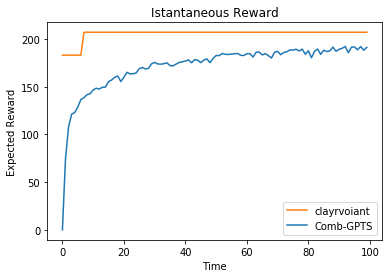

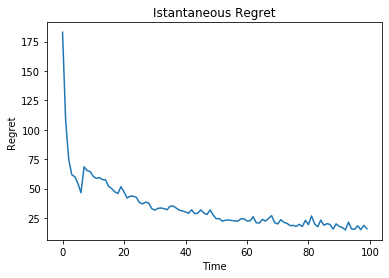

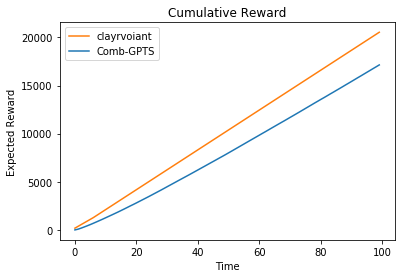

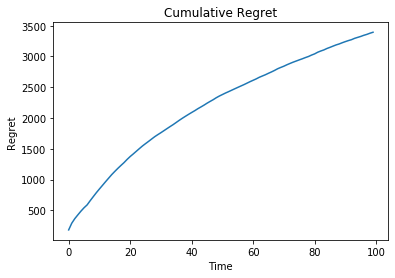

In [0]:
reward_wc = np.average(gpts_rewards_per_experiment_c,axis=0)
clairvoyant_c1 = np.average(clairvoyant_c,axis=0)

plt.figure()
plt.title("Istantaneous Reward")
plt.plot(range(T), clairvoyant_c1, label='clayrvoiant', color="C1")
plt.plot(range(T), reward_wc, label='Comb-GPTS', color="C0")
plt.xlabel("Time")
plt.ylabel("Expected Reward")
plt.legend()
plt.show()

plt.figure()
plt.title("Istantaneous Regret")
plt.plot(range(T), np.absolute(clairvoyant_c1 - reward_wc))
plt.xlabel("Time")
plt.ylabel("Regret")
plt.show()

plt.figure()
plt.title("Cumulative Reward")
plt.plot(range(T), np.cumsum(clairvoyant_c1), label='clayrvoiant', color="C1")
plt.plot(range(T), np.cumsum(reward_wc), label='Comb-GPTS', color="C0")
plt.xlabel("Time")
plt.ylabel("Expected Reward")
plt.legend()
plt.show()

plt.figure()
plt.title("Cumulative Regret")
plt.plot(range(T), np.cumsum(np.absolute(clairvoyant_c1- reward_wc)))
plt.xlabel("Time")
plt.ylabel("Regret")
plt.show()

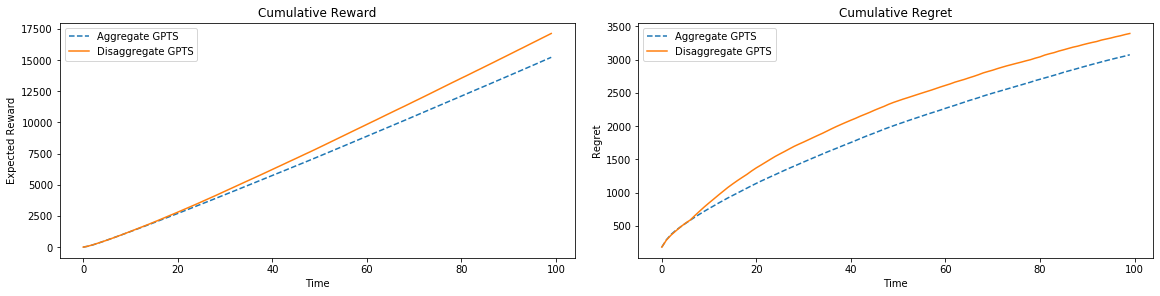

In [0]:
fig, ax = plt.subplots(1, 2, figsize=(16,4), constrained_layout=True)

fmt = "--"      
ax[0].plot(range(T), np.cumsum(reward_nc), fmt, label="Aggregate GPTS")
fmt = "-"      
ax[0].plot(range(T), np.cumsum(reward_wc), fmt, label="Disaggregate GPTS")

ax[0].set_title("Cumulative Reward")
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Expected Reward')
ax[0].legend()

fmt = "--"      
ax[1].plot(range(T),  np.cumsum(np.absolute(T * [clairvoyant] - reward_nc)), fmt, label="Aggregate GPTS")
fmt = "-"      
ax[1].plot(range(T),np.cumsum(np.absolute(clairvoyant_c1- reward_wc)), fmt, label="Disaggregate GPTS")

ax[1].set_title("Cumulative Regret")
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Regret')
ax[1].legend()

plt.show()